In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 100
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.90)
opt = tf.keras.optimizers.Adam()
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]

# y_train = [(i-np.median(j))/iqr(j) for i,j in zip(y_train, x_train)]
# y_val = [(i-np.median(j))/iqr(j) for i,j in zip(y_val, x_val)]
# x_train = [(i-np.median(i))/iqr(i) for i in x_train]
# x_val = [(i-np.median(i))/iqr(i) for i in x_val]


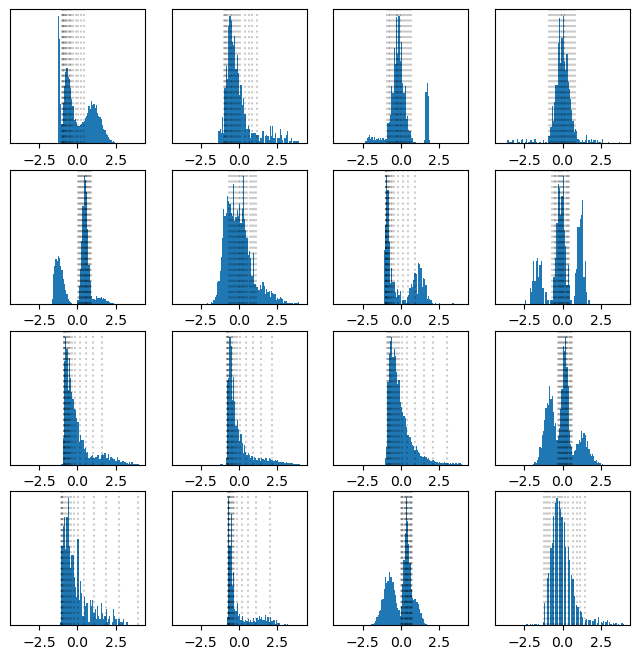

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [6]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [7]:
def extract_features(data):
    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    return features 


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [9]:
x_train.shape

(4800, 100)

In [10]:
y_train.shape


(4800, 16)

In [11]:
# standardize
scalerx = None
# scalerx = RobustScaler()
# x_train = scalerx.fit_transform(x_train)
# x_val = scalerx.transform(x_val)

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [12]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
Total params: 48016 (187.56 KB)
Trainable params: 48016 (187.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/100


I0000 00:00:1716787665.480157    8771 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.26876, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 3s - loss: 0.3156 - val_loss: 0.2688 - 3s/epoch - 6ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.26876 to 0.21801, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.2257 - val_loss: 0.2180 - 2s/epoch - 3ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.21801 to 0.20927, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1992 - val_loss: 0.2093 - 2s/epoch - 3ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.20927
600/600 - 1s - loss: 0.1811 - val_loss: 0.2111 - 1s/epoch - 2ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.20927 to 0.18523, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1707 - val_loss: 0.1852 - 2s/epoch - 3ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.18523 to 0.17675, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1605 - val_loss: 0.1767 - 2s/epoch - 3ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.17675 to 0.17036, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1518 - val_loss: 0.1704 - 2s/epoch - 3ms/step
Epoch 8/100

Epoch 8: val_loss did not improve from 0.17036
600/600 - 1s - loss: 0.1462 - val_loss: 0.1761 - 1s/epoch - 2ms/step
Epoch 9/100

Epoch 9: val_loss did not improve from 0.17036
600/600 - 1s - loss: 0.1421 - val_loss: 0.1756 - 1s/epoch - 2ms/step
Epoch 10/100

Epoch 10: val_loss did not improve from 0.17036
600/600 - 1s - loss: 0.1369 - val_loss: 0.1775 - 1s/epoch - 2ms/step
Epoch 11/100

Epoch 11: val_loss improved from 0.17036 to 0.16654, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1341 - val_loss: 0.1665 - 2s/epoch - 3ms/step
Epoch 12/100

Epoch 12: val_loss did not improve from 0.16654
600/600 - 1s - loss: 0.1275 - val_loss: 0.1671 - 1s/epoch - 2ms/step
Epoch 13/100

Epoch 13: val_loss did not improve from 0.16654
600/600 - 1s - loss: 0.1259 - val_loss: 0.1730 - 1s/epoch - 2ms/step
Epoch 14/100

Epoch 14: val_loss improved from 0.16654 to 0.16178, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1236 - val_loss: 0.1618 - 2s/epoch - 3ms/step
Epoch 15/100

Epoch 15: val_loss did not improve from 0.16178
600/600 - 1s - loss: 0.1212 - val_loss: 0.1625 - 1s/epoch - 2ms/step
Epoch 16/100

Epoch 16: val_loss did not improve from 0.16178
600/600 - 1s - loss: 0.1185 - val_loss: 0.1633 - 1s/epoch - 2ms/step
Epoch 17/100

Epoch 17: val_loss improved from 0.16178 to 0.16085, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1182 - val_loss: 0.1608 - 2s/epoch - 3ms/step
Epoch 18/100

Epoch 18: val_loss improved from 0.16085 to 0.15899, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1150 - val_loss: 0.1590 - 2s/epoch - 3ms/step
Epoch 19/100

Epoch 19: val_loss did not improve from 0.15899
600/600 - 1s - loss: 0.1135 - val_loss: 0.1618 - 1s/epoch - 2ms/step
Epoch 20/100

Epoch 20: val_loss improved from 0.15899 to 0.15499, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1115 - val_loss: 0.1550 - 2s/epoch - 3ms/step
Epoch 21/100

Epoch 21: val_loss improved from 0.15499 to 0.15306, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1101 - val_loss: 0.1531 - 2s/epoch - 3ms/step
Epoch 22/100

Epoch 22: val_loss did not improve from 0.15306
600/600 - 1s - loss: 0.1074 - val_loss: 0.1556 - 1s/epoch - 2ms/step
Epoch 23/100

Epoch 23: val_loss did not improve from 0.15306
600/600 - 1s - loss: 0.1072 - val_loss: 0.1662 - 1s/epoch - 2ms/step
Epoch 24/100

Epoch 24: val_loss did not improve from 0.15306
600/600 - 1s - loss: 0.1061 - val_loss: 0.1594 - 1s/epoch - 2ms/step
Epoch 25/100

Epoch 25: val_loss did not improve from 0.15306
600/600 - 1s - loss: 0.1030 - val_loss: 0.1545 - 1s/epoch - 2ms/step
Epoch 26/100

Epoch 26: val_loss improved from 0.15306 to 0.14995, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.1026 - val_loss: 0.1500 - 2s/epoch - 3ms/step
Epoch 27/100

Epoch 27: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.1009 - val_loss: 0.1531 - 1s/epoch - 2ms/step
Epoch 28/100

Epoch 28: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.0996 - val_loss: 0.1527 - 1s/epoch - 2ms/step
Epoch 29/100

Epoch 29: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.1003 - val_loss: 0.1566 - 1s/epoch - 2ms/step
Epoch 30/100

Epoch 30: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.0973 - val_loss: 0.1539 - 1s/epoch - 2ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.0975 - val_loss: 0.1530 - 1s/epoch - 2ms/step
Epoch 32/100

Epoch 32: val_loss did not improve from 0.14995
600/600 - 1s - loss: 0.0967 - val_loss: 0.1567 - 1s/epoch - 2ms/step
Epoch 33/100

Epoch 33: val_loss improved from 0.14995 to 0.14921, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0936 - val_loss: 0.1492 - 2s/epoch - 3ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.14921
600/600 - 1s - loss: 0.0930 - val_loss: 0.1566 - 1s/epoch - 2ms/step
Epoch 35/100

Epoch 35: val_loss did not improve from 0.14921
600/600 - 1s - loss: 0.0933 - val_loss: 0.1537 - 1s/epoch - 2ms/step
Epoch 36/100

Epoch 36: val_loss improved from 0.14921 to 0.14728, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0911 - val_loss: 0.1473 - 2s/epoch - 3ms/step
Epoch 37/100

Epoch 37: val_loss improved from 0.14728 to 0.14726, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0915 - val_loss: 0.1473 - 2s/epoch - 3ms/step
Epoch 38/100

Epoch 38: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0883 - val_loss: 0.1492 - 1s/epoch - 2ms/step
Epoch 39/100

Epoch 39: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0894 - val_loss: 0.1552 - 1s/epoch - 2ms/step
Epoch 40/100

Epoch 40: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0895 - val_loss: 0.1513 - 1s/epoch - 2ms/step
Epoch 41/100

Epoch 41: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0876 - val_loss: 0.1525 - 1s/epoch - 2ms/step
Epoch 42/100

Epoch 42: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0868 - val_loss: 0.1501 - 1s/epoch - 2ms/step
Epoch 43/100

Epoch 43: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0848 - val_loss: 0.1494 - 1s/epoch - 2ms/step
Epoch 44/100

Epoch 44: val_loss did not improve from 0.14726
600/600 - 1s - loss: 0.0849 - val_loss: 0.1512 - 1s/epoch - 2ms/step
Epoch 45/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0838 - val_loss: 0.1454 - 2s/epoch - 3ms/step
Epoch 46/100

Epoch 46: val_loss did not improve from 0.14537
600/600 - 1s - loss: 0.0827 - val_loss: 0.1492 - 1s/epoch - 2ms/step
Epoch 47/100

Epoch 47: val_loss did not improve from 0.14537
600/600 - 1s - loss: 0.0843 - val_loss: 0.1479 - 1s/epoch - 2ms/step
Epoch 48/100

Epoch 48: val_loss improved from 0.14537 to 0.14430, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0827 - val_loss: 0.1443 - 2s/epoch - 3ms/step
Epoch 49/100

Epoch 49: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0812 - val_loss: 0.1457 - 1s/epoch - 2ms/step
Epoch 50/100

Epoch 50: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0814 - val_loss: 0.1508 - 1s/epoch - 2ms/step
Epoch 51/100

Epoch 51: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0809 - val_loss: 0.1462 - 1s/epoch - 2ms/step
Epoch 52/100

Epoch 52: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0799 - val_loss: 0.1457 - 1s/epoch - 2ms/step
Epoch 53/100

Epoch 53: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0794 - val_loss: 0.1467 - 1s/epoch - 2ms/step
Epoch 54/100

Epoch 54: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0787 - val_loss: 0.1458 - 1s/epoch - 2ms/step
Epoch 55/100

Epoch 55: val_loss did not improve from 0.14430
600/600 - 1s - loss: 0.0773 - val_loss: 0.1501 - 1s/epoch - 2ms/step
Epoch 56/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0755 - val_loss: 0.1441 - 2s/epoch - 3ms/step
Epoch 61/100

Epoch 61: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0747 - val_loss: 0.1476 - 1s/epoch - 2ms/step
Epoch 62/100

Epoch 62: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0757 - val_loss: 0.1460 - 1s/epoch - 2ms/step
Epoch 63/100

Epoch 63: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0735 - val_loss: 0.1469 - 1s/epoch - 2ms/step
Epoch 64/100

Epoch 64: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0733 - val_loss: 0.1472 - 1s/epoch - 2ms/step
Epoch 65/100

Epoch 65: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0732 - val_loss: 0.1463 - 1s/epoch - 2ms/step
Epoch 66/100

Epoch 66: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0729 - val_loss: 0.1475 - 1s/epoch - 2ms/step
Epoch 67/100

Epoch 67: val_loss did not improve from 0.14415
600/600 - 1s - loss: 0.0726 - val_loss: 0.1482 - 1s/epoch - 2ms/step
Epoch 68/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0707 - val_loss: 0.1440 - 2s/epoch - 3ms/step
Epoch 72/100

Epoch 72: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0698 - val_loss: 0.1476 - 1s/epoch - 2ms/step
Epoch 73/100

Epoch 73: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0692 - val_loss: 0.1449 - 1s/epoch - 2ms/step
Epoch 74/100

Epoch 74: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0697 - val_loss: 0.1481 - 1s/epoch - 2ms/step
Epoch 75/100

Epoch 75: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0702 - val_loss: 0.1482 - 1s/epoch - 2ms/step
Epoch 76/100

Epoch 76: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0695 - val_loss: 0.1484 - 1s/epoch - 2ms/step
Epoch 77/100

Epoch 77: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0681 - val_loss: 0.1465 - 1s/epoch - 2ms/step
Epoch 78/100

Epoch 78: val_loss did not improve from 0.14401
600/600 - 1s - loss: 0.0690 - val_loss: 0.1468 - 1s/epoch - 2ms/step
Epoch 79/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


600/600 - 2s - loss: 0.0641 - val_loss: 0.1432 - 2s/epoch - 3ms/step
Epoch 90/100

Epoch 90: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0650 - val_loss: 0.1438 - 1s/epoch - 2ms/step
Epoch 91/100

Epoch 91: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0633 - val_loss: 0.1458 - 1s/epoch - 2ms/step
Epoch 92/100

Epoch 92: val_loss did not improve from 0.14319
600/600 - 2s - loss: 0.0645 - val_loss: 0.1481 - 2s/epoch - 3ms/step
Epoch 93/100

Epoch 93: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0633 - val_loss: 0.1450 - 1s/epoch - 2ms/step
Epoch 94/100

Epoch 94: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0628 - val_loss: 0.1483 - 1s/epoch - 2ms/step
Epoch 95/100

Epoch 95: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0626 - val_loss: 0.1472 - 1s/epoch - 2ms/step
Epoch 96/100

Epoch 96: val_loss did not improve from 0.14319
600/600 - 1s - loss: 0.0618 - val_loss: 0.1471 - 1s/epoch - 2ms/step
Epoch 97/100



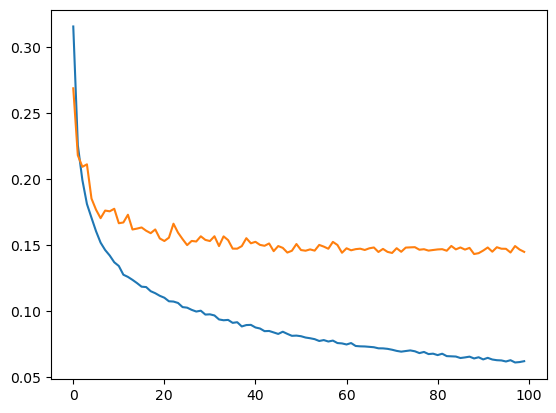

In [14]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [15]:
# save scalers
# with open(output_path+'/model_x_scaler.pkl', 'wb') as f:
#     pickle.dump(scalerx, f)
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
